In [ ]:
import data
import torch
from models import imagebind_model
from models.imagebind_model import ModalityType

text_list=["A dog.", "A car", "A bird"]
image_paths=[".assets/dog_image.jpg", ".assets/car_image.jpg", ".assets/bird_image.jpg"]
audio_paths=[".assets/dog_audio.wav", ".assets/car_audio.wav", ".assets/bird_audio.wav"]

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

# Load data
inputs = {
    ModalityType.TEXT: data.load_and_transform_text(text_list, device),
    ModalityType.VISION: data.load_and_transform_vision_data(image_paths, device),
    ModalityType.AUDIO: data.load_and_transform_audio_data(audio_paths, device),
}

with torch.no_grad():
    embeddings = model(inputs)

print(
    "Vision x Text: ",
    torch.softmax(embeddings[ModalityType.VISION] @ embeddings[ModalityType.TEXT].T, dim=-1),
)
print(
    "Audio x Text: ",
    torch.softmax(embeddings[ModalityType.AUDIO] @ embeddings[ModalityType.TEXT].T, dim=-1),
)
print(
    "Vision x Audio: ",
    torch.softmax(embeddings[ModalityType.VISION] @ embeddings[ModalityType.AUDIO].T, dim=-1),
)

# Expected output:
#
# Vision x Text:
# tensor([[9.9761e-01, 2.3694e-03, 1.8612e-05],
#         [3.3836e-05, 9.9994e-01, 2.4118e-05],
#         [4.7997e-05, 1.3496e-02, 9.8646e-01]])
#
# Audio x Text:
# tensor([[1., 0., 0.],
#         [0., 1., 0.],
#         [0., 0., 1.]])
#
# Vision x Audio:
# tensor([[0.8070, 0.1088, 0.0842],
#         [0.1036, 0.7884, 0.1079],
#         [0.0018, 0.0022, 0.9960]])


In [ ]:
torch.softmax(embeddings[ModalityType.VISION] @ embeddings[ModalityType.AUDIO].T, dim=-1)

In [ ]:
from models.multimodal_preprocessors import PatchEmbedGeneric,PadIm2Video
import torch.nn as nn
import numpy as np
from typing import Optional
class PatchEmbedGeneric(nn.Module):
    """
    PatchEmbed from Hydra
    """

    def __init__(self, proj_stem, norm_layer: Optional[nn.Module] = None):
        super().__init__()

        if len(proj_stem) > 1:
            self.proj = nn.Sequential(*proj_stem)
        else:
            # Special case to be able to load pre-trained models that were
            # trained with a standard stem
            self.proj = proj_stem[0]
        self.norm_layer = norm_layer

    def get_patch_layout(self, img_size):
        with torch.no_grad():
            dummy_img = torch.zeros(
                [
                    1,
                ]
                + img_size
            )
            print(dummy_img.shape)
            dummy_out = self.proj(dummy_img)
        print(dummy_out.shape)
        embed_dim = dummy_out.shape[1]
        patches_layout = tuple(dummy_out.shape[2:])
        num_patches = np.prod(patches_layout)
        return patches_layout, num_patches, embed_dim

    def forward(self, x):
        print(x.shape)
        x = self.proj(x)
        print(x.shape)
        # B C (T) H W -> B (T)HW C
        x = x.flatten(2).transpose(1, 2)
        print(x.shape)
        if self.norm_layer is not None:
            x = self.norm_layer(x)
        return x
    
kernel_size=(2, 14, 14)
vision_embed_dim=1024
proj_stem=[
                PadIm2Video(pad_type="repeat", ntimes=2),
                nn.Conv3d(
                    in_channels=3,
                    kernel_size=kernel_size,
                    out_channels=vision_embed_dim,
                    stride=kernel_size,
                    bias=False,
                )
]
PatchEmbedGeneric(proj_stem,None).get_patch_layout([3, 2,224, 224])

In [ ]:
from models.helpers import VerboseNNModule
from typing import Tuple, Optional, Callable
from models.helpers import (EinOpsRearrange, LearnableLogitScaling, Normalize,
                            SelectElement, SelectEOSAndProject)
from models.multimodal_preprocessors import (AudioPreprocessor,
                                             IMUPreprocessor, PadIm2Video,
                                             PatchEmbedGeneric,
                                             RGBDTPreprocessor,
                                             SpatioTemporalPosEmbeddingHelper,
                                             TextPreprocessor,
                                             ThermalPreprocessor)
from models.transformer import MultiheadAttention, SimpleTransformer

import logging
import os
from functools import partial
from types import SimpleNamespace
from typing import Dict

import torch
import torch.nn as nn

class RGBDTPreprocessor(VerboseNNModule):
    def __init__(
        self,
        rgbt_stem: PatchEmbedGeneric,
        depth_stem: Optional[PatchEmbedGeneric],
        img_size: Tuple = (3, 224, 224),
        num_cls_tokens: int = 1,
        pos_embed_fn: Optional[Callable] = None,
        use_type_embed: bool = False,
        init_param_style: str = "openclip",
    ) -> None:
        super().__init__()
        stem = rgbt_stem if rgbt_stem is not None else depth_stem
        (
            self.patches_layout,
            self.num_patches,
            self.embed_dim,
        ) = stem.get_patch_layout(img_size)
        self.rgbt_stem = rgbt_stem
        self.depth_stem = depth_stem
        self.use_pos_embed = pos_embed_fn is not None
        self.use_type_embed = use_type_embed
        self.num_cls_tokens = num_cls_tokens

        if self.use_pos_embed:
            self.pos_embedding_helper = pos_embed_fn(
                patches_layout=self.patches_layout,
                num_cls_tokens=num_cls_tokens,
                num_patches=self.num_patches,
                embed_dim=self.embed_dim,
            )
        if self.num_cls_tokens > 0:
            self.cls_token = nn.Parameter(
                torch.zeros(1, self.num_cls_tokens, self.embed_dim)
            )
        if self.use_type_embed:
            self.type_embed = nn.Parameter(torch.zeros(1, 1, self.embed_dim))

        self.init_parameters(init_param_style)

    @torch.no_grad()
    def init_parameters(self, init_param_style):
        if init_param_style == "openclip":
            # OpenCLIP style initialization
            scale = self.embed_dim**-0.5
            if self.use_pos_embed:
                nn.init.normal_(self.pos_embedding_helper.pos_embed)
                self.pos_embedding_helper.pos_embed *= scale

            if self.num_cls_tokens > 0:
                nn.init.normal_(self.cls_token)
                self.cls_token *= scale
        elif init_param_style == "vit":
            self.cls_token.data.fill_(0)
        else:
            raise ValueError(f"Unknown init {init_param_style}")

        if self.use_type_embed:
            nn.init.normal_(self.type_embed)

    def tokenize_input_and_cls_pos(self, input, stem, mask):
        # tokens is of shape B x L x D
        tokens = stem(input)
        assert tokens.ndim == 3
        assert tokens.shape[2] == self.embed_dim
        B = tokens.shape[0]
        if self.num_cls_tokens > 0:
            class_tokens = self.cls_token.expand(
                B, -1, -1
            )  # stole class_tokens impl from Phil Wang, thanks
            tokens = torch.cat((class_tokens, tokens), dim=1)
        if self.use_pos_embed:
            pos_embed = self.pos_embedding_helper.get_pos_embedding(input, tokens)
            tokens = tokens + pos_embed
        if self.use_type_embed:
            tokens = tokens + self.type_embed.expand(B, -1, -1)
        return tokens

    def forward(self, vision=None, depth=None, patch_mask=None):
        if patch_mask is not None:
            raise NotImplementedError()

        if vision is not None:
            vision_tokens = self.tokenize_input_and_cls_pos(
                vision, self.rgbt_stem, patch_mask
            )

        if depth is not None:
            depth_tokens = self.tokenize_input_and_cls_pos(
                depth, self.depth_stem, patch_mask
            )

        # aggregate tokens
        if vision is not None and depth is not None:
            final_tokens = vision_tokens + depth_tokens
        else:
            final_tokens = vision_tokens if vision is not None else depth_tokens
        return_dict = {
            "trunk": {
                "tokens": final_tokens,
            },
            "head": {},
        }
        return return_dict

rgbt_stem = PatchEmbedGeneric(
            proj_stem=[
                PadIm2Video(pad_type="repeat", ntimes=2),
                nn.Conv3d(
                    in_channels=3,
                    kernel_size=kernel_size,
                    out_channels=vision_embed_dim,
                    stride=kernel_size,
                    bias=False,
                ),
            ]
        )

rgbt_preprocessor = RGBDTPreprocessor(
            img_size=[3, 2, 224, 224],
            num_cls_tokens=1,
            pos_embed_fn=partial(SpatioTemporalPosEmbeddingHelper, learnable=True),
            rgbt_stem=rgbt_stem,
            depth_stem=None,
        )

rgbt_preprocessor(dummy_img[0])['trunk']['tokens'].shape

In [2]:
from models.imagebind_model import ImageBindModel
imageBind=ImageBindModel()

In [10]:
import torch
dummy_img = torch.zeros(
                [1,3,1,224,224]
            )
imageBind.layer_shapes(dummy_img,modality_type="vision")

input torch.Size([1, 3, 1, 224, 224])
trunk_inputs shape torch.Size([1, 257, 1024])
after trunk shape torch.Size([1, 257, 1024])
after head shape torch.Size([1, 768])
postprocessor shape torch.Size([1, 768])


In [ ]:
import torch
path='.checkpoints/imagebind_huge.pth'
state_dict = torch.load(path)

In [ ]:
state_dict['modality_heads.thermal.2.weight'].shape

In [ ]:
[keys for keys in state_dict.keys() if 'thermal' in keys]

In [ ]:
[key for key in state_dict.keys() if key.startswith("modality_preprocessors.thermal")]

In [1]:
from models.events import EventModel
e=EventModel()
e

/opt/conda/envs/imagebind/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
e.event_preprocessor.cls_token

Parameter containing:
tensor([[[ 0.0491, -0.0587, -0.0083,  ..., -0.0046,  0.0354,  0.0301]]],
       requires_grad=True)

In [3]:
e.event_preprocessor.state_dict()['cls_token']

tensor([[[ 0.0491, -0.0587, -0.0083,  ..., -0.0046,  0.0354,  0.0301]]])

In [4]:
e.load_weights(path='.checkpoints/imagebind_huge.pth')

In [4]:

path='/tsukimi/datasets/Chiba/finetune_train/HL-HC-Official-2023_12_04_14_10_37-100.pkl'
import pickle as pkl
import torch
import numpy as np
import torchvision.transforms as transforms
import cv2
from datasets.EventDataset import events_to_image_torch as e2i
with open(path, 'rb') as f:
    data = pkl.load(f)
def resize_pad(frame, size=224):
    """
    resize a frame's longer side to 224, pad the shorter side to 224
    """

    # get shape
    c, h, w = frame.shape

    # get longer side
    longer_side = max(h, w)

    # calculate ratio
    ratio = size / longer_side

    # resize with transform
    resize_transform = transforms.Resize((int(h * ratio), int(w * ratio)))
    frame = resize_transform(frame)

    # get new shape
    c, h, w = frame.shape

    # calculate padding needed to reach size for both dimensions
    pad_height = (size - h) if h < size else 0
    pad_width = (size - w) if w < size else 0

    # calculate padding for each side to center the image
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left

    # apply padding
    padding_transform = transforms.Pad(padding=(pad_left, pad_top, pad_right, pad_bottom), fill=0, padding_mode='constant')
    frame = padding_transform(frame)

    return frame
frame_normalize = transforms.Compose([
                resize_pad,
                transforms.Normalize([0.153, 0.153, 0.153], [0.165, 0.165, 0.165])])
image_list = data['images'] 
image_list=[cv2.cvtColor(np.array(image),cv2.COLOR_BGR2RGB) for image in image_list]
image_list = np.stack(image_list, axis=0)
image_units = torch.from_numpy(image_list).float() / 255 
image_units=image_units.permute(0,3, 1, 2) 
image_units = [frame_normalize(image_units[i]) for i in range(image_units.shape[0])]
image_units = torch.stack(image_units)
image_units=image_units.permute(1,0,2,3)
print(image_units.shape)

torch.Size([3, 2, 224, 224])


In [18]:
data['events'][1].shape

(224,)

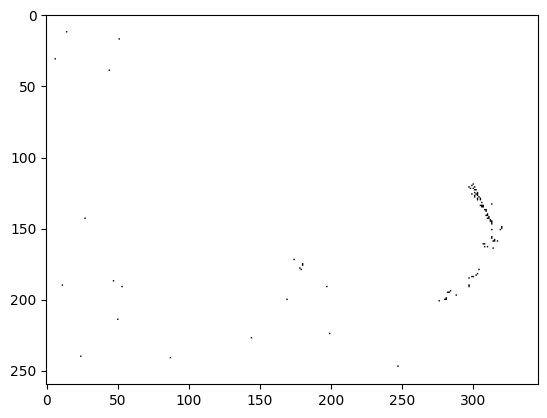

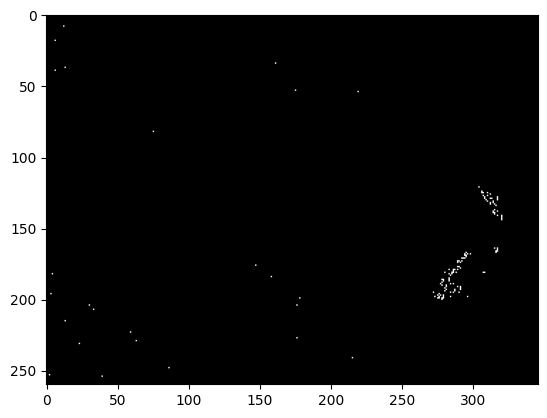

In [7]:
events=data['events'][0]
events['polarity'][events['polarity']==0]=-1
events_positive=events[events['polarity']==1]
events_negative=events[events['polarity']==-1]
event_frame_positive=e2i(events_positive['x'],events_positive['y'],events_positive['polarity'])
event_frame_negative=e2i(events_negative['x'],events_negative['y'],events_negative['polarity'])
#find the indexes where eventframe not equals to 0
import matplotlib.pyplot as plt
plt.imshow(event_frame_negative, cmap='gray')
plt.show()
plt.imshow(event_frame_positive, cmap='gray')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


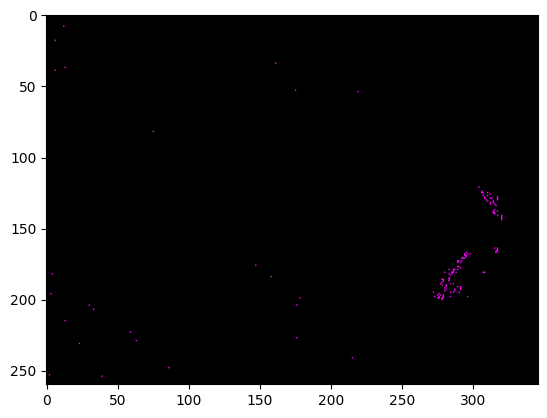

In [55]:
# concat image
import numpy as np
event_frame=np.stack([event_frame_positive,event_frame_negative,event_frame_positive+event_frame_negative])
plt.imshow(np.transpose(event_frame,(1, 2, 0)))

In [12]:
from datasets.EventDataset import events_to_image_torch as e2it
import torch
events=data['events'][0]
events['polarity'][events['polarity']==0]=-1
events_positive=events[events['polarity']==1]
events_negative=events[events['polarity']==-1]

# deep compare e2it(events_negative['x'],events_negative['y'],events_negative['polarity']) and event_frame_negative
events_positive_frame=e2it(events_positive['x'],events_positive['y'],events_positive['polarity'])
events_negative_frame=e2it(events_negative['x'],events_negative['y'],events_negative['polarity'])
event_frame=torch.stack([events_positive_frame,events_negative_frame,events_positive_frame+events_negative_frame],dim=0)
event_frame.shape

torch.Size([3, 260, 346])

In [1]:
dummy_path={'train':['/tsukimi/datasets/Chiba/finetune_train/HL-HC-Official-2023_12_04_14_10_37-100.pkl']}
import pickle
#save dummy_path
with open('dummy_path.pkl', 'wb') as f:
    pickle.dump(dummy_path, f)

In [1]:
from datasets.EventDataset import EventDataset
import numpy as np
import torch

eventdataset=EventDataset(mode='train',data_dir='/tsukimi/datasets/Chiba/finetune_train/')

/opt/conda/envs/imagebind/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/imagebind/lib/python3.8/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/opt/conda/envs/imagebind/lib/python3.8/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [2]:
from torch.utils.data import DataLoader
loader=DataLoader(eventdataset,batch_size=2,shuffle=True)
video,videoch,events,eventch=next(iter(loader))
from train_events import ImageBindTrain
train=ImageBindTrain()

In [7]:
with torch.no_grad():
    output=train.info_nce_loss(next(iter(loader)))
    print(output)

tensor(6.1192)


: 

In [1]:
from models import imagebind_model
from models.events import EventModel
model = imagebind_model.imagebind_huge(pretrained=True)
eventmodel=EventModel()
eventmodel.apply_event_layers(model)

/opt/conda/envs/imagebind/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (audio): AudioPreprocessor(
      (cls_token): tensor((1, 1, 768), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10), bias=False)
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=

In [2]:
from models.imagebind_model import ModalityType
model.modality_preprocessors[ModalityType.EVENT]

EventPreprocessor(
  (cls_token): tensor((1, 1, 1280), requires_grad=True)
  
  (rgbt_stem): PatchEmbedGeneric(
    (proj): Sequential(
      (0): PadIm2Video()
      (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
  )
  (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
    (pos_embed): tensor((1, 257, 1280), requires_grad=True)
    
  )
)

In [5]:
import torch
from models.imagebind_model import ModalityType
img=eventdataset[0][0]
event=eventdataset[0][2]
with torch.no_grad():
    inputs={ModalityType.VISION:img.unsqueeze(0),ModalityType.EVENT:event.unsqueeze(0)}
    model.modality_preprocessors[ModalityType.EVENT](event.unsqueeze(0))
    model(inputs)

In [10]:
from models.multimodal_preprocessors import  PadIm2Video
img=eventdataset[0][0]
PadIm2Video(pad_type="repeat", ntimes=2)(img).shape

torch.Size([3, 2, 2, 224, 224])

(17, 260, 346)


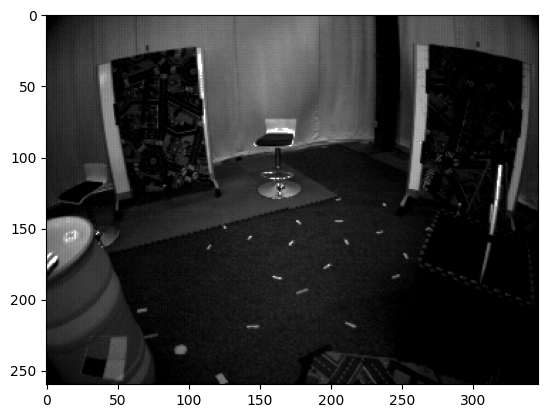

In [48]:
import pickle 
path='/tsukimi/datasets/MVSEC/mvsec_event_chunks_v2ce/indoor_flying1_data_left-1.pkl'
path2='/tsukimi/datasets/MVSEC/mvsec_event_chunks_v2ce/indoor_flying1_data_left-108.pkl'
# load data
with open(path2, 'rb') as f:
    data = pickle.load(f)
print(data['images'].shape)
# show image
import numpy as np
import cv2
import matplotlib.pyplot as plt
image_list = data['images']
image_units=[]
for i in range(len(data['images'])):
    image=data['images'][i]
    # convert to 3 channels
    image=np.repeat(image[...,None],3,axis=2).transpose(2,0,1)
    image_units.append(image)
image_units = np.stack([image_units[:-1], image_units[1:]], axis=1) # 16, 2, 3, 260, 346
image_units.shape
# show first image
plt.imshow(image_units[0][0].transpose(1,2,0))

In [45]:
from tqdm import tqdm
def background_filter(events, frame_size=(260, 346), dt=70000):
    """ Filter out the background.
        Works by looking at the last shooting time of a certain event's location.
        If the last event at the same position is too long ago, discard it. 
    Args:
        events: ndarray, shape:(ta, 4), the events stream
        frame_size: tuple/list, (h, w), the frame size
        dt: int, threshold of 'long time' in us.
    Returns:
        events_filtered: ndarray, shape: (?, 4), filtered events.
    """
    h, w = frame_size
    ta = events.shape[0]
    lastTimesMap = np.zeros((w, h))
    index = np.zeros(ta)
    for i in tqdm(range(ta), total=ta):
        ts, xs, ys, ps = events[i]
        deltaT = ts-lastTimesMap[xs, ys]
        if deltaT > dt:
            index[i] = np.nan
        lastTimesMap[max(0, xs-1):min(w, xs+1), max(0, ys-1):min(h, ys+1)] = ts

    events_filtered = events[~(np.isnan(index))]
    return events_filtered

def hot_pixel_filter(events, frame_size=(260, 346), thres_percentile=99):
    """ Filter out the Hot Pixels.
        Hot pixels are defined as the pixels that record a number of event
        bigger than threventhotpixel.
    Args:
        events: ndarray, shape:(ta, 4), the events stream
        frame_size: tuple/list, (h, w), the frame size
        thres_percentile: float, 0~100, threshold percentile of hot pixel.
    Returns:
        events_filtered: ndarray, shape: (?, 4), filtered events.
    """
    # h, w = frame_size

    # hotpixelarray = aggregate(events[:, 1:3].T, np.ones_like(
    #     events[:, 0]), func='sum', size=(w, h), fill_value=0)
    # threventhotpixel = np.percentile(hotpixelarray.flatten(), thres_percentile)
    # selindexarray = hotpixelarray >= threventhotpixel
    # [hpx, hpy] = np.nonzero(selindexarray.astype(int))
    # fs = np.array((hpx, hpy)).T

    # events_filtered = events[~(events[:, 1:3] == fs[:, None]).all(-1).any(axis=0)]
    # return events_filtered
    h, w = frame_size
    hotpixelarray = np.zeros(frame_size, dtype=np.int)
    for x, y in zip(events['x'], events['y']):
        if 0 <= x < w and 0 <= y < h:
            hotpixelarray[y, x] += 1
    threventhotpixel = np.percentile(hotpixelarray.flatten(), thres_percentile)
    
    # event_counts = hotpixelarray.flatten()
    # mean_count = np.mean(event_counts)
    # median_count = np.median(event_counts)
    # std_dev = np.std(event_counts)
    # threventhotpixel = max(np.percentile(event_counts, thres_percentile),median_count+50)
    
    selindexarray = hotpixelarray > threventhotpixel
    hpx, hpy = np.nonzero(selindexarray.astype(int))
    mask = np.ones(len(events), dtype=bool)  # Start with all True
    for x, y in zip(hpy, hpx):
        mask &= ~((events['x'] == x) & (events['y'] == y))
    events_filtered = events[mask]
    return events_filtered

In [49]:
import torch
from torchvision import transforms
def resize_pad(frame, size=224):
    """
    resize a frame's longer side to 224, pad the shorter side to 224
    """

    # get shape
    c, h, w = frame.shape

    # get longer side
    longer_side = max(h, w)

    # calculate ratio
    ratio = size / longer_side

    # resize with transform
    resize_transform = transforms.Resize((int(h * ratio), int(w * ratio)))
    frame = resize_transform(frame)

    # get new shape
    c, h, w = frame.shape

    # calculate padding needed to reach size for both dimensions
    pad_height = (size - h) if h < size else 0
    pad_width = (size - w) if w < size else 0

    # calculate padding for each side to center the image
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left

    # apply padding
    padding_transform = transforms.Pad(padding=(pad_left, pad_top, pad_right, pad_bottom), fill=0, padding_mode='constant')
    frame = padding_transform(frame)

    return frame
def events_to_image_torch(xs, ys, ps,
        device=None, sensor_size=(260, 346), clip_out_of_range=False,
        interpolation=None, padding=True, default=0):
    """
    Method to turn event tensor to image. Allows for bilinear interpolation.
    @param xs Tensor of x coords of events
    @param ys Tensor of y coords of events
    @param ps Tensor of event polarities/weights
    @param device The device on which the image is. If none, set to events device
    @param sensor_size The size of the image sensor/output image
    @param clip_out_of_range If the events go beyond the desired image size,
       clip the events to fit into the image
    @param interpolation Which interpolation to use. Options=None,'bilinear'
    @param padding If bilinear interpolation, allow padding the image by 1 to allow events to fit:
    @returns Event image from the events
    """
    xs=torch.tensor(xs.copy(), dtype=torch.long)
    ys = torch.tensor(ys.copy(), dtype=torch.long)
    ps = torch.tensor(ps.copy(),dtype=torch.float32)
    
    if device is None:
        device = xs.device
    img_size = list(sensor_size)

    mask = torch.ones(xs.size(), device=device)
    if clip_out_of_range:
        zero_v = torch.tensor([0.], device=device)
        ones_v = torch.tensor([1.], device=device)
        clipx = img_size[1] if interpolation is None and padding==False else img_size[1]-1
        clipy = img_size[0] if interpolation is None and padding==False else img_size[0]-1
        mask = torch.where(xs>=clipx, zero_v, ones_v)*torch.where(ys>=clipy, zero_v, ones_v)

    img = (torch.ones(img_size)*default).to(device)
    if xs.dtype is not torch.long:
        xs = xs.long().to(device)
    if ys.dtype is not torch.long:
        ys = ys.long().to(device)
    try:
        mask = mask.long().to(device)
        xs, ys = xs*mask, ys*mask
        img.index_put_((ys, xs), ps, accumulate=True)
    except Exception as e:
        print("Unable to put tensor {} positions ({}, {}) into {}. Range = {},{}".format(
            ps.shape, ys.shape, xs.shape, img.shape,  torch.max(ys), torch.max(xs)))
        raise e
    return img


eventframes=[]
for events in data['events']:
    events['polarity'][events['polarity']==0]=-1
    events_positive=events[events['polarity']==1]
    events_negative=events[events['polarity']==-1]
    events_positive_frame=events_to_image_torch(events_positive['x'],events_positive['y'],events_positive['polarity'])
    events_negative_frame=events_to_image_torch(events_negative['x'],events_negative['y'],events_negative['polarity'])
    event_frame=torch.stack([events_positive_frame,events_negative_frame,events_positive_frame+events_negative_frame],dim=0)
    event_frame=resize_pad(event_frame)
    
    eventframes.append(event_frame)
eventframes=torch.stack(eventframes)

In [51]:
eventframes[0][2].max()

tensor(2.2657)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


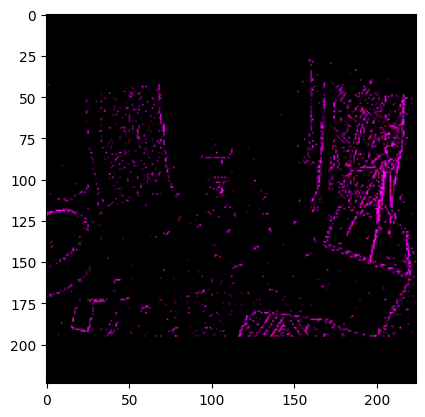

In [53]:
plt.imshow(eventframes[0][2])

In [46]:
events=data['events'][0]
events=hot_pixel_filter(events)
img=events_to_image_torch(events['x'],events['y'],events['polarity'])
img=torch.stack([img,img,img],dim=0)
img=resize_pad(img)

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations